## Setup
```bash
python3 -m venv .venv084
source .venv084/bin/activate  
pip install -U pip setuptools wheel
pip install pyrosm geopandas shapely fiona pyproj rtree matplotlib jupyterlab ipykernel folium
python -m ipykernel install --user --name=env84 --display-name "Python (env084)"
```

Run Jupyter and change to the relevant Kernel.

In [1]:
from pathlib import Path
from pyrosm import OSM

# ▶️ Chemin vers ton PBF (à adapter)
PBF_PATH = Path("../osm-data-setup/c084.osm.pbf")
osm = OSM(PBF_PATH.as_posix())
print("Loaded PBF:", PBF_PATH)

BOUNDS_WIDE  = [4.60, 43.60, 5.90, 44.50]
#BOUNDS_TIGHT = [4.70, 43.70, 5.60, 44.40]
print("Using bounds:", BOUNDS_WIDE)

Loaded PBF: ../osm-data-setup/c084.osm.pbf
Using bounds: [4.6, 43.6, 5.9, 44.5]


## Buildings

In [2]:
buildings = osm.get_buildings()
print('Buildings rows:', 0 if buildings is None else len(buildings))
buildings.head() if buildings is not None else None

Buildings rows: 500201


,addr:city,addr:country,addr:full,addr:housenumber,addr:housename,addr:postcode,addr:place,addr:street,email,name,...,source,start_date,wikipedia,id,timestamp,version,tags,osm_type,geometry,changeset
0,Ménerbes,None,None,None,None,None,None,None,None,Église Saint-Luc,...,cadastre-dgi-fr source : Direction Générale de...,None,None,32690142,1715075868,12,"{""check_date"":""2024-05-07"",""denomination"":""cat...",way,"POLYGON ((5.20249 43.83548, 5.2028 43.83553, 5...",NaN
1,None,None,None,None,None,None,None,None,None,La Citadelle,...,cadastre-dgi-fr source : Direction Générale de...,None,None,32690464,1347610728,7,"{""castle_type"":""citadel"",""castle_type:fr"":""cit...",way,"POLYGON ((5.20527 43.83307, 5.20528 43.83307, ...",NaN
2,None,None,None,None,Mairie,None,None,None,None,Mairie de Ménerbes,...,cadastre-dgi-fr source : Direction Générale de...,None,None,32690467,1745241999,11,"{""contact:email"":""contact@menerbes.fr"",""contac...",way,"POLYGON ((5.20419 43.83421, 5.20413 43.83417, ...",NaN
3,None,None,None,None,None,None,None,None,None,Chapelle St Blaise,...,cadastre-dgi-fr source : Direction Générale de...,None,None,32690915,1715077328,6,"{""check_date"":""2024-05-07"",""denomination"":""cat...",way,"POLYGON ((5.20535 43.83261, 5.20532 43.83259, ...",NaN
4,None,None,None,None,None,None,None,None,None,Le Castellet,...,cadastre-dgi-fr source : Direction Générale de...,None,None,32691772,1258913903,4,None,way,"POLYGON ((5.20181 43.83645, 5.202 43.83652, 5....",NaN


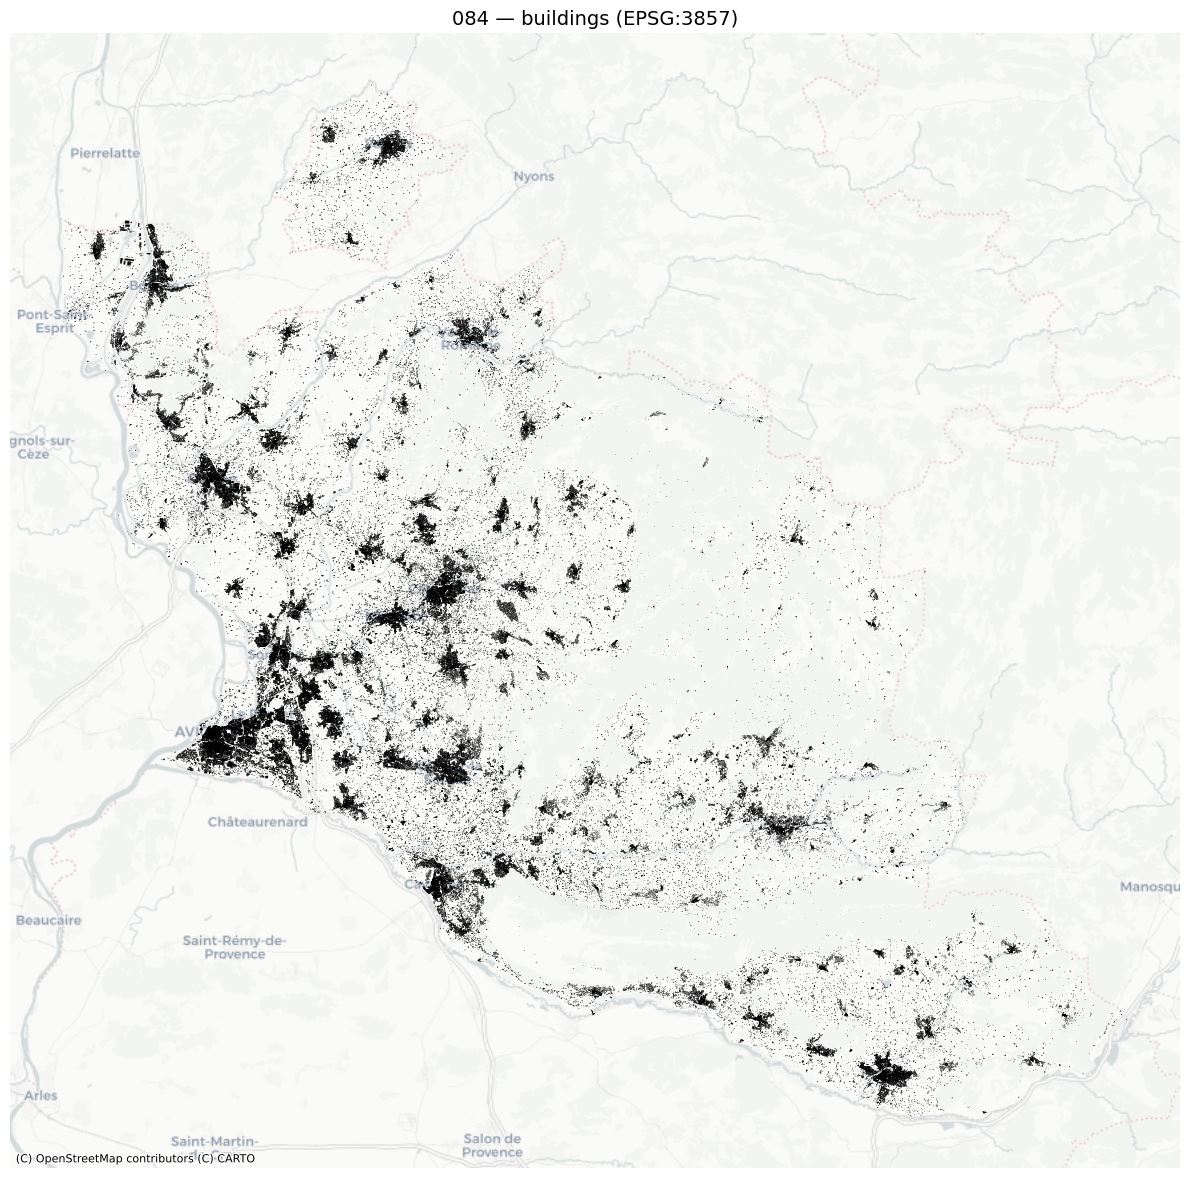

In [7]:
import matplotlib.pyplot as plt
import contextily as ctx

b3857 = buildings.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 12))

b3857.plot(ax=ax, color="black", edgecolor="black", linewidth=0.2)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.set_axis_off()
ax.set_title("084 — buildings (EPSG:3857)", fontsize=14) 
plt.tight_layout()
plt.show()

## Agriculture

In [4]:
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from pyrosm import OSM
import geopandas as gpd
from shapely import validation

PBF_PATH = Path("../osm-data-setup/c084.osm.pbf")
BOUNDS_WIDE  = [4.60, 43.60, 5.90, 44.50]

AGRI_TAGS = {
    "farmland", "farm", "meadow", "pasture", "vineyard", "orchard",
    "greenhouse_horticulture", "plant_nursery", "allotments",
    "farmyard", "horticulture"
}

osm = OSM(PBF_PATH.as_posix(), bounding_box=BOUNDS_WIDE)

landuse = osm.get_data_by_custom_criteria(
    custom_filter={"landuse": True},
    filter_type="keep",
    osm_keys_to_keep=["landuse", "name", "natural", "leisure", "landcover", "boundary"],
    keep_nodes=False,
    keep_ways=True,
    keep_relations=True
)

landuse = landuse[landuse.geometry.notna()]
landuse = landuse[landuse.geom_type.isin(["Polygon", "MultiPolygon"])]
landuse = landuse[landuse["landuse"].notna()]

if not landuse.is_valid.all():
    landuse["geometry"] = landuse["geometry"].apply(
        lambda g: validation.make_valid(g) if not g.is_valid else g
    )

agri = landuse[landuse["landuse"].isin(AGRI_TAGS)].copy()

print("Agricultural rows:", 0 if agri is None else len(agri))
agri.head() if agri is not None else None

Agricultural rows: 74112


,basin,cemetery,commercial,conservation,construction,depot,industrial,landfill,landuse,meadow,...,railway,residential,vineyard,id,timestamp,version,tags,osm_type,geometry,changeset
3205,None,None,None,None,None,None,None,None,meadow,None,...,None,None,None,38634289,1351434659,5,"{""visible"":false}",way,"POLYGON ((5.05583 43.91749, 5.05577 43.91748, ...",NaN
3462,None,None,None,None,None,None,None,None,vineyard,None,...,None,None,None,41685897,1724919104,6,"{""visible"":false,""crop"":""grape""}",way,"POLYGON ((5.01722 44.14243, 5.01707 44.14228, ...",NaN
3464,None,None,None,None,None,None,None,None,vineyard,None,...,None,None,None,41686106,1746076631,33,"{""visible"":false,""CLC:code"":""221"",""CLC:id"":""FR...",way,"POLYGON ((5.38722 43.74475, 5.38718 43.74461, ...",NaN
3465,None,None,None,None,None,None,None,None,vineyard,None,...,None,None,None,41738291,1745247867,15,"{""visible"":false,""CLC:code"":""221"",""CLC:id"":""FR...",way,"POLYGON ((4.79249 44.19913, 4.79102 44.19883, ...",NaN
3466,None,None,None,None,None,None,None,None,orchard,None,...,None,None,None,41738551,1692704157,7,"{""visible"":false,""CLC:code"":""222"",""CLC:id"":""FR...",way,"POLYGON ((4.85564 44.23735, 4.85646 44.23741, ...",NaN


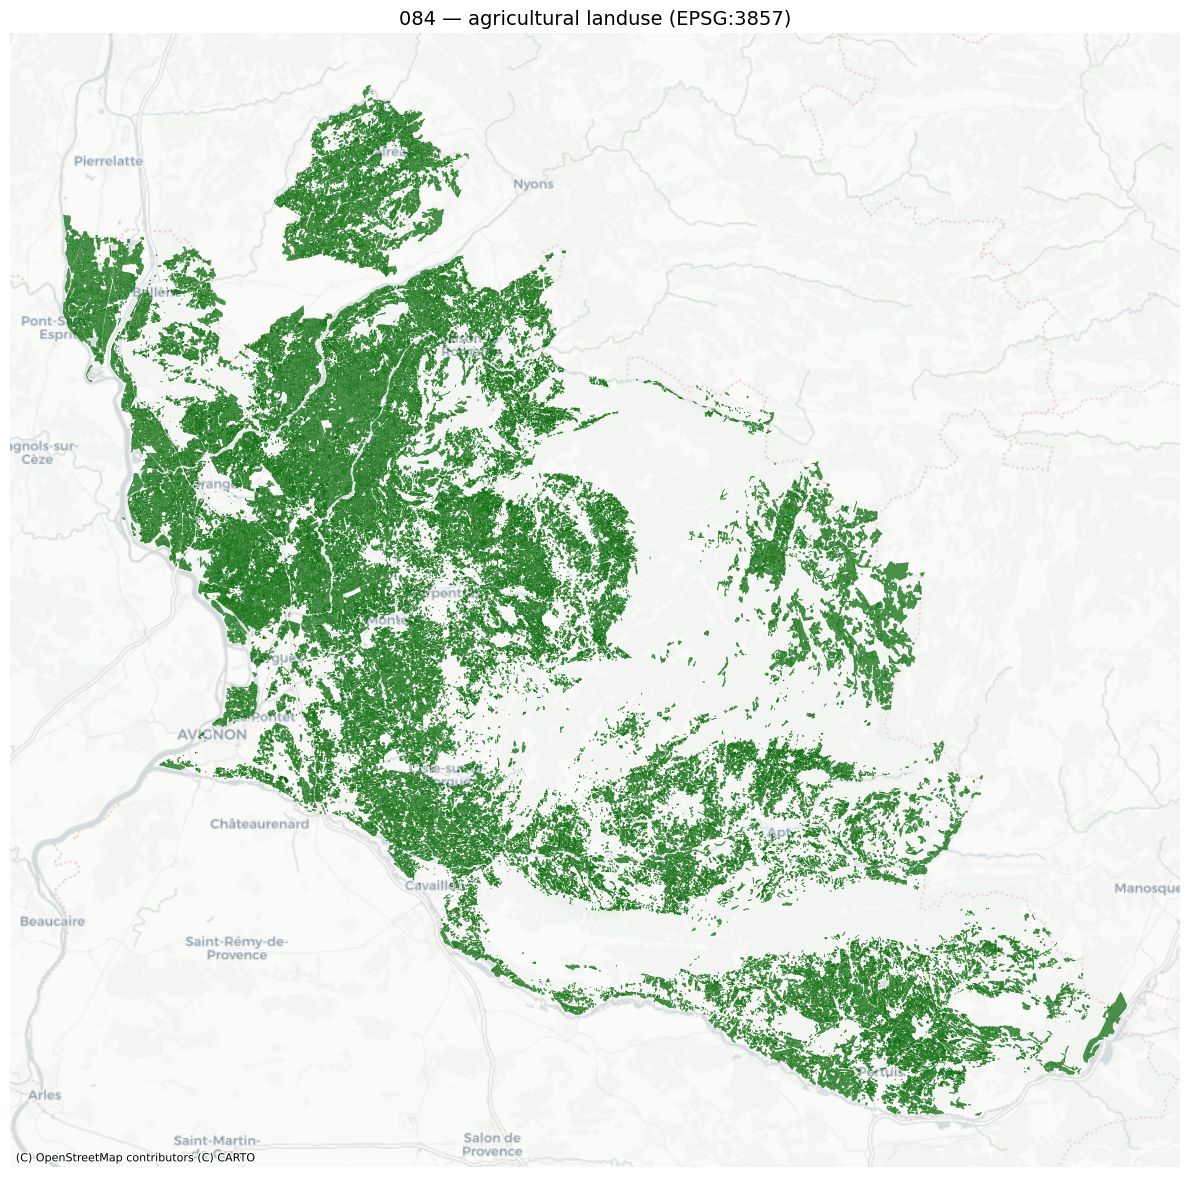

In [6]:
import matplotlib.pyplot as plt
import contextily as ctx

if agri is None or agri.empty:
    raise RuntimeError("No agricultural features to plot")

agri_3857 = agri.to_crs(epsg=3857)
agri_3857["area_m2"] = agri_3857.area
agri_3857 = agri_3857[agri_3857["area_m2"] >= 2_000].copy()

fig, ax = plt.subplots(figsize=(12, 12))
agri_3857.plot(ax=ax, color="darkgreen", edgecolor="darkgreen", linewidth=0.3, alpha=0.7)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
ax.set_title("084 — agricultural landuse (EPSG:3857)", fontsize=14)
plt.tight_layout()
plt.show()